In [1]:
#paths & device
from pathlib import Path
import torch, json, numpy as np

BASE = Path.home() / "projects" / "office-ssl"
LAB = BASE / "data" / "labeled"
IMG_DIR = LAB / "images"
ANNOT_CSV = LAB / "annotations.csv"
MODEL_SAVE = BASE / "final_model.pth"   # change if you saved elsewhere
OUT_JSON = BASE / "logs" / "detect_classify_results.json"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)


device: cuda


In [10]:
#Load finetuned model + thresholds + label map
from pathlib import Path
import torch, json, numpy as np
from src.simclr import SimCLRModel
from src.finetune import MultiLabelFineTune

BASE = Path.home() / "projects" / "office-ssl"
device = "cuda" if torch.cuda.is_available() else "cpu"

LABEL_MAP = BASE / "data/labeled/label_map.json"
label_map = json.load(open(LABEL_MAP))
num_classes = len(label_map)

# 1) Load backbone from SimCLR
simclr_ckpt = sorted((BASE / "checkpoints").glob("simclr-epoch*.ckpt"))[-1]
simclr = SimCLRModel.load_from_checkpoint(str(simclr_ckpt), strict=False)
backbone = simclr.backbone.to(device).eval()

# 2) Load best finetune checkpoint
ft_ckpt = sorted((BASE / "checkpoints").glob("finetune-*.ckpt"))[-1]
ck = torch.load(ft_ckpt, map_location=device)["state_dict"]

# 3) Build model
finetuned = MultiLabelFineTune(
    backbone=backbone,
    num_classes=num_classes
).to(device).eval()

# 4) Clean keys and load
clean = {}
for k,v in ck.items():
    k2 = k.replace("model.", "")
    clean[k2] = v

finetuned.load_state_dict(clean, strict=False)

print("Model loaded successfully")

# Load thresholds or fallback
MODEL_SAVE = BASE / "final_model.pth"
if MODEL_SAVE.exists():
    ck2 = torch.load(MODEL_SAVE, map_location=device)
    best_thresh = np.array(ck2["thresholds"], dtype=float)
    print("Loaded thresholds:", best_thresh)
else:
    best_thresh = np.full((num_classes,), 0.17)
    print("Using fallback threshold = 0.17")


/home/syed-mohammed-bilal/.local/share/mamba/envs/office_ssl/lib/python3.11/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

Model loaded successfully
Loaded thresholds: [0.26122449 0.21530612 0.13265306 0.15102041 0.3255102  0.10510204
 0.07755102 0.13265306 0.1877551  0.38061224 0.08673469 0.14183673
 0.43571429 0.1877551  0.12346939 0.27040816 0.09591837 0.25204082
 0.2244898 ]


/tmp/ipykernel_20987/615411604.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck2 = torch.load(MODEL_SAVE, map_location=device)


In [28]:
#Install/init detector & transforms (MTCNN)
from facenet_pytorch import MTCNN
import torchvision.transforms as T
import torchvision.io as io
import torchvision.transforms.functional as F
from torchvision.transforms.functional import to_pil_image

# 1) Robust image loader (Torch -> PIL)
def safe_load_image(path):
    """
    Loads ANY image using torchvision backend (libjpeg-turbo),
    then converts to PIL for MTCNN.
    """
    try:
        img = io.read_image(str(path))          # C,H,W (uint8)
        img = img[:3]                            # ensure RGB (drop alpha)
        img = F.convert_image_dtype(img, torch.float32)
        pil = to_pil_image(img)                  # convert to PIL for MTCNN
        return pil
    except Exception as e:
        print("FAILED to load:", path, "|", e)
        return None

# 2) Init detector
mtcnn = MTCNN(keep_all=True, device=device)

# 3) Transform for classifier crops — match training transforms
face_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])



/home/syed-mohammed-bilal/.local/share/mamba/envs/office_ssl/lib/python3.11/site-packages/facenet_pytorch/models/mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

In [12]:
#Helper: enlarge & crop safely
def enlarge_box(box, w, h, pad=0.25):
    # box: [x1,y1,x2,y2]
    x1,y1,x2,y2 = box
    bw = max(1, x2-x1); bh = max(1, y2-y1)
    x1n = max(0, int(x1 - pad*bw))
    y1n = max(0, int(y1 - pad*bh))
    x2n = min(w, int(x2 + pad*bw))
    y2n = min(h, int(y2 + pad*bh))
    return x1n,y1n,x2n,y2n


In [13]:
#Batch classify helper (efficient)
import numpy as np
import torch.nn.functional as F

def classify_pil_crops(pil_crops, batch_size=64):
    """
    pil_crops: list of PIL.Image
    returns: np.array shape (N, num_classes) of probs
    """
    if len(pil_crops)==0:
        return np.zeros((0, num_classes), dtype=float)
    tensors = [face_transform(c).unsqueeze(0) for c in pil_crops]
    x = torch.cat(tensors, dim=0).to(device)  # (N,3,224,224)
    probs = []
    with torch.no_grad():
        for i in range(0, x.size(0), batch_size):
            xb = x[i:i+batch_size]
            # get backbone features
            feat = finetuned.backbone(xb)
            if feat.ndim==4:
                feat = torch.nn.functional.adaptive_avg_pool2d(feat, (1,1)).reshape(feat.size(0), -1)
            logits = finetuned.classifier(feat)  # (B, C)
            p = torch.sigmoid(logits).cpu().numpy()
            probs.append(p)
    probs = np.vstack(probs)
    return probs


In [29]:
#Per-image pipeline: detect, crop, classify, aggregate
from tqdm import tqdm
import json

def detect_classify_image(image_path, pad=0.25, batch_size=64, thr=None):
    # Load with robust torchvision backend → PIL (safe for corrupted files)
    pil = safe_load_image(image_path)
    if pil is None:
        return {
            'image': str(image_path),
            'error': 'unreadable',
            'boxes': [],
            'crop_probs': [],
            'crop_preds': [],
            'agg_preds': []
        }

    W, H = pil.size

    # Run detector
    boxes, probs_mtcnn = mtcnn.detect(pil)

    # Prepare output structure
    result = {
        'image': str(image_path),
        'boxes': [],
        'crop_probs': [],
        'crop_preds': [],
        'agg_preds': []
    }

    if boxes is None or len(boxes) == 0:
        return result

    # Enlarge & crop
    crops = []
    coords = []

    for box in boxes:
        x1, y1, x2, y2 = enlarge_box(box, W, H, pad=pad)
        coords.append((int(x1), int(y1), int(x2), int(y2)))
        crops.append(pil.crop((x1, y1, x2, y2)))

    # Batch-classify all crops
    probs = classify_pil_crops(crops, batch_size=batch_size)

    # If no external thresholds passed: use best_thresh from file
    if thr is None:
        thr = best_thresh

    preds_bin = (probs >= thr).astype(int)         # crop-level binary preds
    agg = (preds_bin.sum(axis=0) > 0).astype(int)  # aggregated scene label

    # Fill output
    result['boxes'] = coords
    result['crop_probs'] = probs.tolist()
    result['crop_preds'] = preds_bin.tolist()
    result['agg_preds'] = agg.tolist()

    return result



In [30]:
#run detection + classification for all labeled images
BASE = Path.home() / "projects" / "office-ssl"
LABELED = BASE / "data" / "labeled"
IMG_DIR = LABELED / "images"

OUT_JSON = BASE / "results" / "step3_face_scene_predictions.json"

valid_ext = {".jpg", ".jpeg", ".png", ".webp", ".bmp"}

# Collect all valid files — ignore directories
img_paths = [
    p for p in IMG_DIR.iterdir()
    if p.is_file() and p.suffix.lower() in valid_ext
]

img_paths = sorted(img_paths)
print("Found", len(img_paths), "images.")

# Run detector + classifier
results = []
for p in tqdm(img_paths, desc="Detect + Classify"):
    res = detect_classify_image(p, pad=0.25, batch_size=128, thr=best_thresh)
    results.append(res)

# Save output
OUT_JSON.parent.mkdir(parents=True, exist_ok=True)
with open(OUT_JSON, "w") as f:
    json.dump(results, f, indent=2)

print("Saved results to", OUT_JSON)


Found 500 images.


Detect + Classify: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:55<00:00,  9.02it/s]

Saved results to /home/syed-mohammed-bilal/projects/office-ssl/results/step3_face_scene_predictions.json


In [31]:
#Evaluate per-image (method: max per-class crop prob)
import pandas as pd
from sklearn.metrics import average_precision_score, f1_score, hamming_loss

ann = pd.read_csv(ANNOT_CSV).set_index('filename')
# build preds_probs_image: for each class, max crop prob in image
preds_probs = []
targets = []
filenames = []
for r in results:
    fname = Path(r['image']).name
    filenames.append(fname)
    crop_probs = np.array(r['crop_probs'])  # NxC or empty
    if crop_probs.size==0:
        probs_img = np.zeros((num_classes,))
    else:
        probs_img = crop_probs.max(axis=0)
    preds_probs.append(probs_img)
    # target vector
    if fname in ann.index:
        labs = ann.loc[fname, 'labels']
        labs = [] if pd.isna(labs) else labs.split(';')
        t = np.zeros((num_classes,), dtype=int)
        for l in labs:
            if l in label_map:
                t[int(label_map[l])] = 1
    else:
        t = np.zeros((num_classes,), dtype=int)
    targets.append(t)
preds_probs = np.vstack(preds_probs)
targets = np.vstack(targets)

# AP per-class
aps = [average_precision_score(targets[:,i], preds_probs[:,i]) if targets[:,i].sum()>0 else np.nan for i in range(num_classes)]
print("Mean AP (image-level, max-prob):", np.nanmean(aps))

# F1 with saved per-class thresholds (apply threshold array to probs)
preds_bin = (preds_probs >= best_thresh).astype(int)
print("Macro-F1 (calibrated):", f1_score(targets, preds_bin, average='macro', zero_division=0))
print("Hamming loss:", hamming_loss(targets, preds_bin))


Mean AP (image-level, max-prob): 0.25463233555473336
Macro-F1 (calibrated): 0.16400722490747063
Hamming loss: 0.18705263157894736


Saved: /home/syed-mohammed-bilal/projects/office-ssl/figures/step3_samples/7fe7abfe__d31c08c0-166_annotated.png


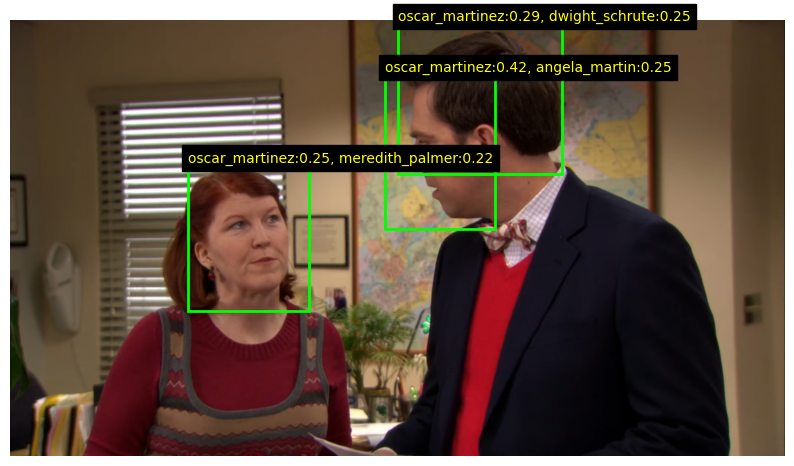

Saved: /home/syed-mohammed-bilal/projects/office-ssl/figures/step3_samples/21b189d7__037f5f3c-471_annotated.png


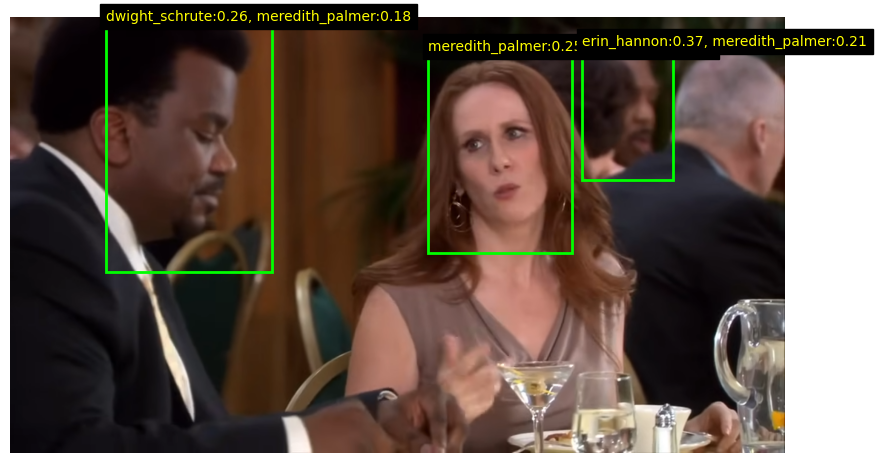

Saved: /home/syed-mohammed-bilal/projects/office-ssl/figures/step3_samples/c64673f1__97cc9344-67_annotated.png


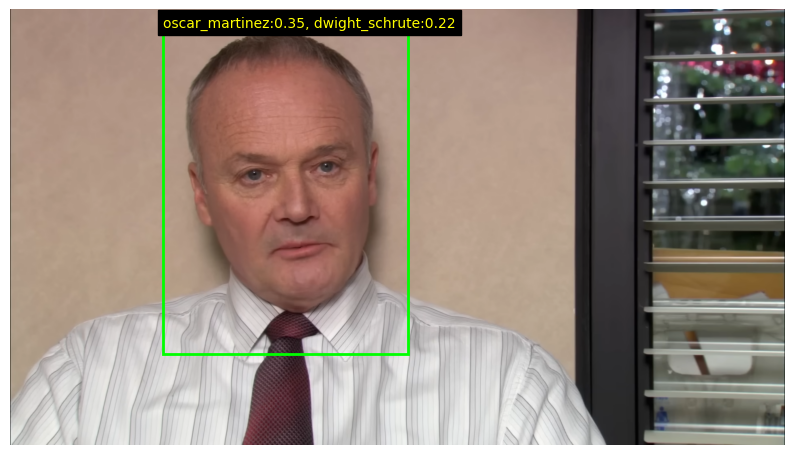

Saved: /home/syed-mohammed-bilal/projects/office-ssl/figures/step3_samples/b3bf904c__bf675ed4-392_annotated.png


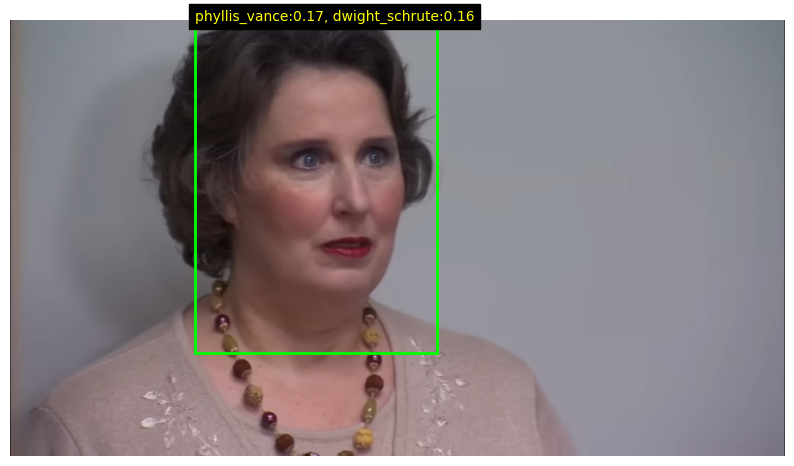

Saved: /home/syed-mohammed-bilal/projects/office-ssl/figures/step3_samples/6ca24a86__119bdc83-311_annotated.png


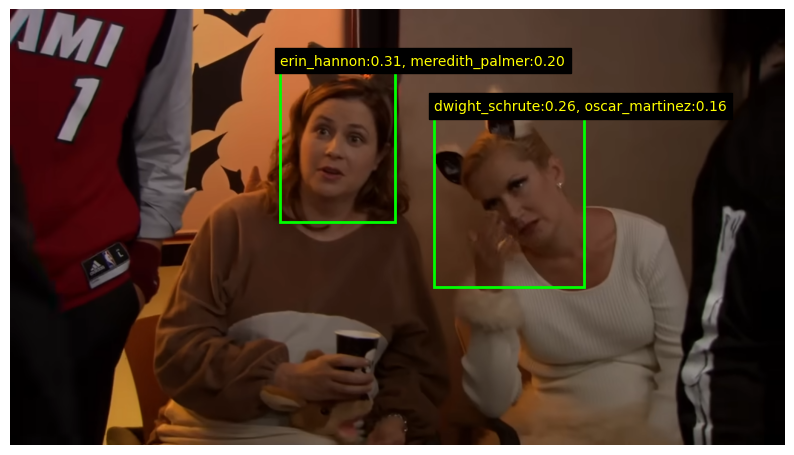

In [66]:
# visualize-and-save (
import random, numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path

OUT_DIR = BASE / "figures" / "step3_samples"
OUT_DIR.mkdir(parents=True, exist_ok=True)

def draw_and_save_matplotlib(result, top_k=2, save=True, show=True):
    """
    Draw bounding boxes + top-k labels on image using matplotlib (avoids Pillow C-API bugs).
    Saves annotated image to OUT_DIR if save=True.
    """
    img_path = Path(result['image'])
    pil = safe_load_image(img_path)   # returns PIL Image or None
    if pil is None:
        print("Skipping unreadable:", img_path)
        return

    # convert to numpy for matplotlib
    img_np = np.array(pil)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img_np)
    ax.axis('off')

    boxes = result.get('boxes', [])
    crop_probs = np.array(result.get('crop_probs')) if len(result.get('crop_probs', []))>0 else None

    for i, box in enumerate(boxes):
        x1,y1,x2,y2 = box
        w = x2 - x1
        h = y2 - y1
        # rectangle
        rect = Rectangle((x1,y1), w, h, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

        # label text
        label_text = ""
        if crop_probs is not None and crop_probs.shape[0] > i:
            probs = crop_probs[i]
            top_idx = probs.argsort()[-top_k:][::-1]
            label_text = ", ".join([f"{idx_to_name[idx]}:{probs[idx]:.2f}" for idx in top_idx])

        # place text (matplotlib)
        ax.text(x1, max(0, y1 - 8), label_text, color='yellow', fontsize=10, backgroundcolor='black')

    # save to disk
    if save:
        out_path = OUT_DIR / f"{img_path.stem}_annotated.png"
        fig.savefig(out_path, bbox_inches='tight', pad_inches=0.1, dpi=200)
        print("Saved:", out_path)

    if show:
        plt.show()
    plt.close(fig)


# show & save 5 random examples
sample = random.sample(results, min(5, len(results)))
for r in sample:
    draw_and_save_matplotlib(r, top_k=2, save=True, show=True)


In [67]:
#final results CSV
import pandas as pd
from pathlib import Path

csv_path = BASE / "results" / "step3_predictions.csv"
csv_path.parent.mkdir(parents=True, exist_ok=True)

rows = []
for r in results:
    fname = Path(r["image"]).name
    agg = r["agg_preds"]
    labels = [idx_to_name[i] for i, v in enumerate(agg) if v == 1]

    rows.append({
        "filename": fname,
        "predicted_labels": ";".join(labels),
        "n_faces": len(r.get("boxes", [])),
    })

df = pd.DataFrame(rows)
df.to_csv(csv_path, index=False)

print("Saved:", csv_path)


Saved: /home/syed-mohammed-bilal/projects/office-ssl/results/step3_predictions.csv


In [68]:
#saving model weights(backbone + classifier + thresholds)
final_model_path = BASE / "results" / "final_model_full.pth"
torch.save({
    "state_dict": finetuned.state_dict(),
    "thresholds": best_thresh,
    "label_map": label_map,
}, final_model_path)

print("Saved:", final_model_path)


Saved: /home/syed-mohammed-bilal/projects/office-ssl/results/final_model_full.pth
